In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

# from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from src.SFBC.convLayer import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

# from cutlass import *
# from rbfConv import *
from tqdm.autonotebook import tqdm
import random 
import numpy as np
from src.test_case_II.datautils import splitFile
from src.test_case_II.datautils import datasetLoader, loadFrame
from src.SFBC.detail.windows import getWindowFunction
from src.test_case_II.util import constructFluidFeatures
from src.SFBC.convNet import RbfNet
from datetime import datetime
import portalocker
from src.SFBC.detail.augment import augment
from src.test_case_II.training import processBatch
# from datautils import *
# from sphUtils import *
# from lossFunctions import *

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from src.test_case_II.util import setSeeds, loadDataset, getDataLoader, getFeatureSizes
from src.SFBC.detail.util import count_parameters
import json
from src.test_case_II.util import NumpyArrayEncoder
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from src.test_case_IV.training import loadFrame, runNetwork
from src.SFBC.detail.scatter import scatter_sum
from src.test_case_IV.eval import getUnrollFrame

cm = mpl.colormaps['viridis']
import matplotlib.colors as colors
import h5py

/tmp/ipykernel_577796/2037001457.py:74: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:

from src.test_case_IV.radius import periodicNeighborSearchXYZ
from src.SFBC.detail.scatter import scatter_sum
from src.test_case_IV.util import generateGrid, optimizeVolume
from src.test_case_IV.simplex import getSimplexNoisePeriodic3, _init
from src.test_case_IV.util import wendland, wendlandGrad

perm, _perm_grad_index3 = _init(1234)

In [4]:
n = 16

maxDomain = [1,1,1]
minDomain = [-1,-1,-1]
numNeighbors = 50
nx = ny = nz = n

gridPositions, xx, yy, zz = generateGrid(nx, ny, nz)
volume = 2**3 / (nx * ny * nz)
support = (numNeighbors * volume / (4/3 * np.pi))**(1/3)
volume = optimizeVolume(gridPositions, minDomain, maxDomain, support, steps = 16)


In [5]:
from src.test_case_IV.plotting import plotSlices
from src.test_case_IV.util import genData

In [6]:
parameterDict = {
    'nx' : n, 'ny' : n, 'nz': n,
    'support': support, 'minDomain': minDomain, 'maxDomain': maxDomain,
    'numNeighbors': numNeighbors, 'dx': 2 / nx, 'volume': volume,
    'simplexFrequency': 0.2, 'simplexScale': 1.05 / 2, 'jitterMean': 0,'jitterAmount': 0.015
}
parameterDict = {
    'nx' : n, 'ny' : n, 'nz': n,
    'support': support, 'minDomain': minDomain, 'maxDomain': maxDomain,
    'numNeighbors': numNeighbors, 'dx': 2 / nx, 'volume': volume,
    'simplexFrequency': 0.1, 'simplexScale': 1.05 / 2, 'jitterMean': 0,'jitterAmount': 0.00
}
generatedData = genData(xx,yy,zz,gridPositions, 1234567, parameterDict, simplexFrequency = None)

/home/winchenbach/dev/SFBC/src/test_case_IV/util.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vols = parameterDict['volume'] *  torch.tensor(vol.flatten())


<IPython.core.display.Javascript object>


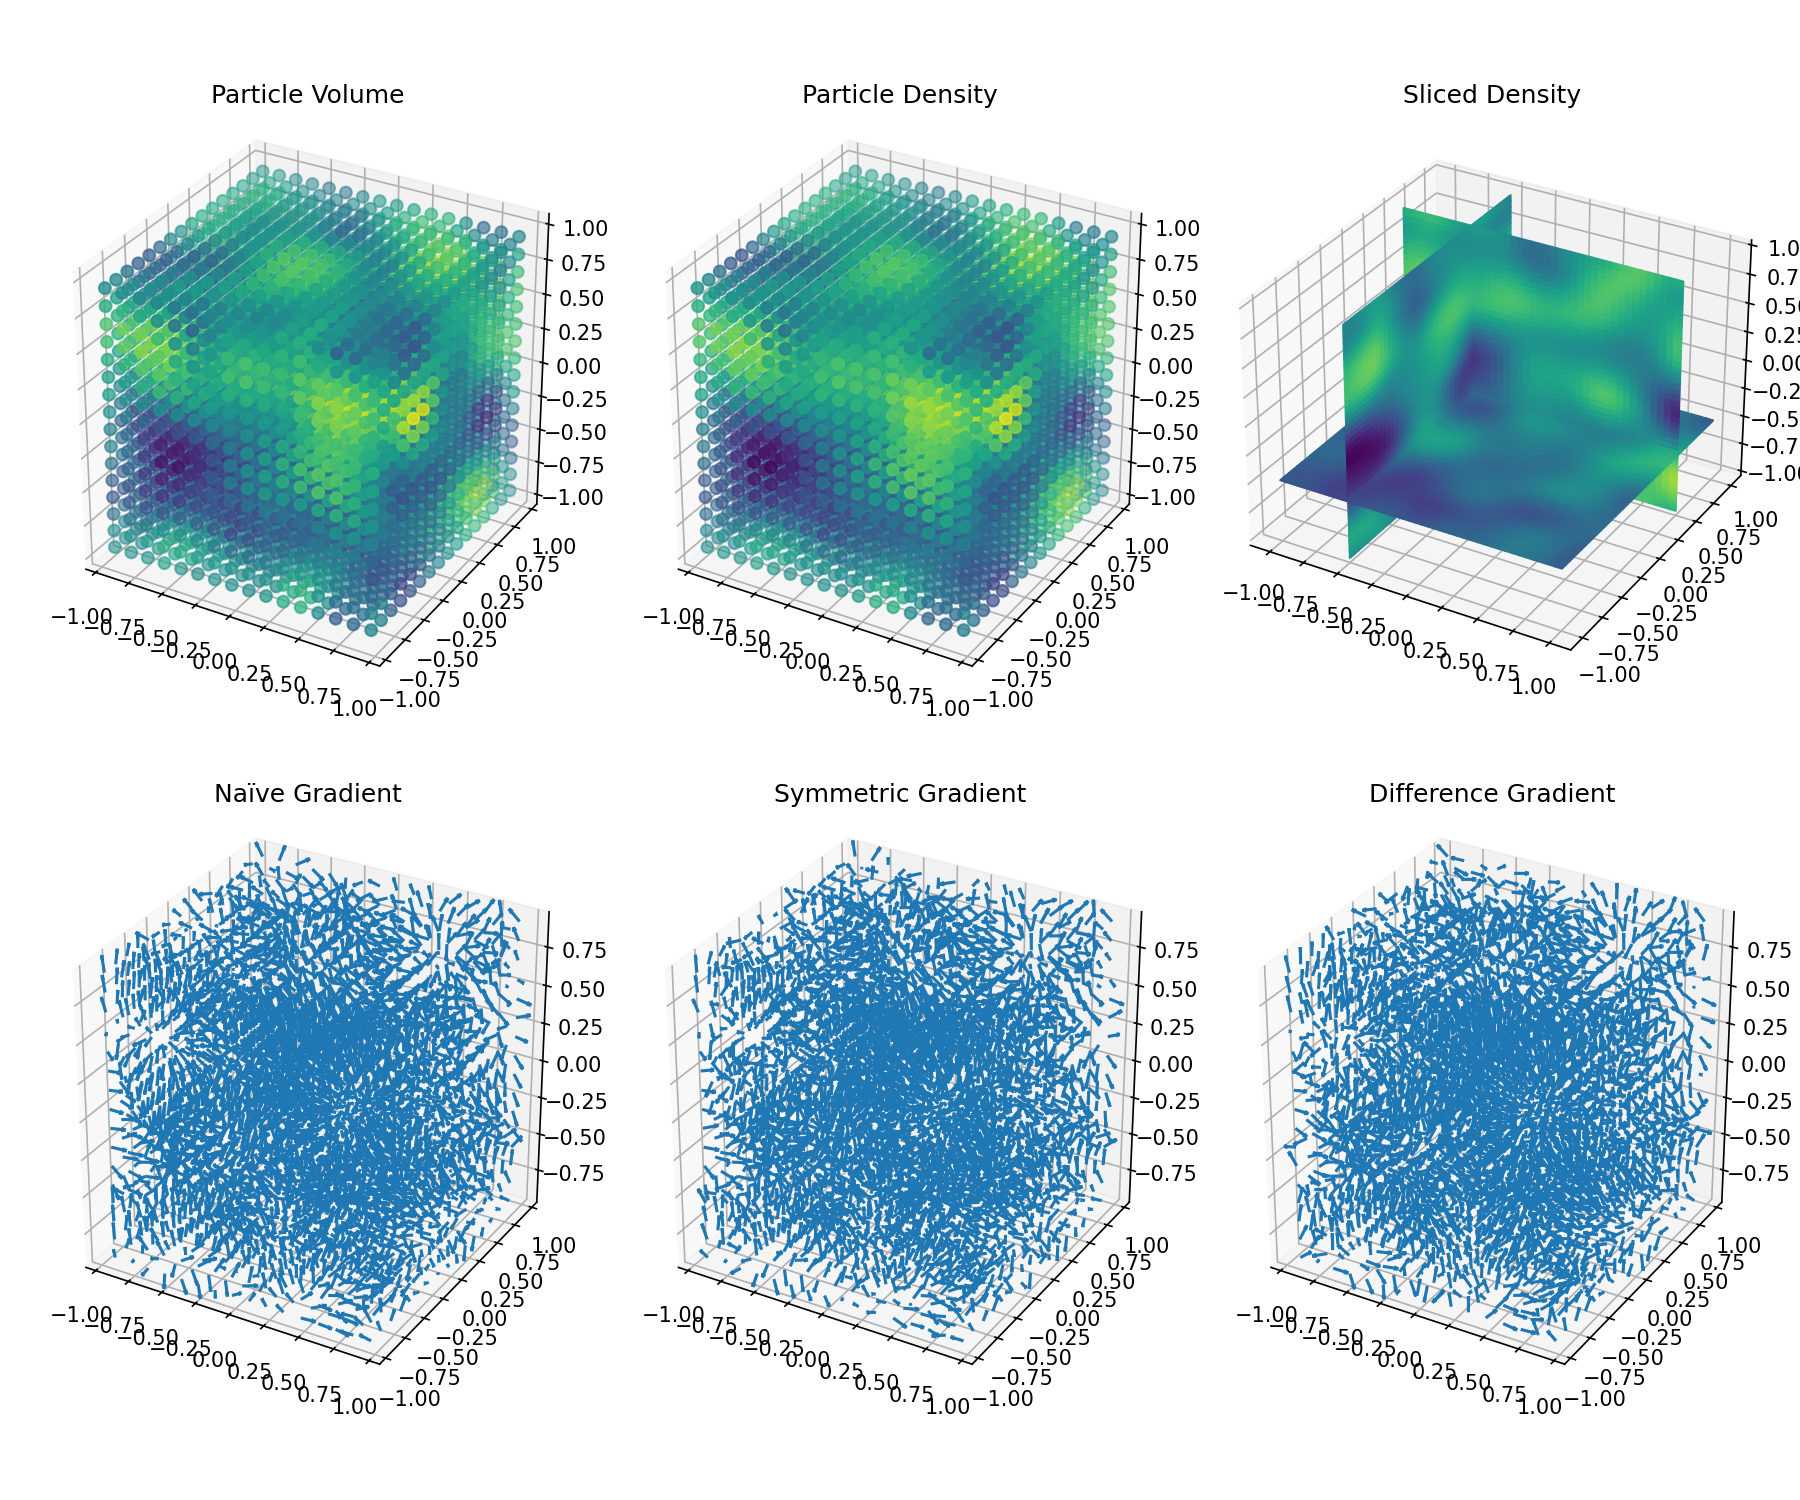

/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/matplotlib/backends/backend_nbagg.py:181: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm('matplotlib', data={'id': self.uuid})


In [7]:
x = generatedData['x']
vols = generatedData['vols']
cm = mpl.colormaps['viridis']
norm = colors.Normalize(vmin = torch.min(generatedData['rho']), vmax = torch.max(generatedData['rho']))
def func(_planePositions):
    planePositions = _planePositions.type(torch.float32)
    fp, ff, rij, dist = periodicNeighborSearchXYZ(x.type(torch.float32), planePositions, minDomain, maxDomain, support, True, True )
    rho = scatter_sum(vols[ff] * wendland(dist, support), fp, dim = 0, dim_size = planePositions.shape[0])
    return rho

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(2, 3, 1, projection='3d')
sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = generatedData['vols'], s = 32)
# fig.colorbar(sc, ax=ax)
ax.set_box_aspect([1,1,1]) 
ax.set_title('Particle Volume')

ax = fig.add_subplot(2, 3, 2, projection='3d')
sc = ax.scatter(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], c = generatedData['rho'], s = 32)
# fig.colorbar(sc, ax=ax)
ax.set_box_aspect([1,1,1]) 
ax.set_title('Particle Density')

ax = fig.add_subplot(2, 3, 3, projection='3d')
nPoints  = 32
sc = plotSlices(fig, ax, cm = cm,norm = norm, func = func, z = -0.5, nPoints = nPoints)
# fig.colorbar(mpl.cm.ScalarMappable(cmap = cm, norm = norm), ax=ax)
ax.set_title('Sliced Density')

ax = fig.add_subplot(2, 3, 4, projection='3d')
ax.quiver(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], generatedData['gradRhoNaive'][:,0], generatedData['gradRhoNaive'][:,1], generatedData['gradRhoNaive'][:,2], normalize = True, length = 0.1)
ax.set_box_aspect([1,1,1]) 
ax.set_title('Naïve Gradient')
# fig.colorbar(sc, ax=ax)
ax = fig.add_subplot(2, 3, 5, projection='3d')
ax.quiver(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], generatedData['gradRhoSymmetric'][:,0], generatedData['gradRhoSymmetric'][:,1], generatedData['gradRhoSymmetric'][:,2], normalize = True, length = 0.1)
ax.set_box_aspect([1,1,1]) 
ax.set_title('Symmetric Gradient')
# fig.colorbar(sc, ax=ax)
ax = fig.add_subplot(2, 3, 6, projection='3d')
ax.quiver(generatedData['x'][:,0], generatedData['x'][:,1], generatedData['x'][:,2], generatedData['gradRhoDifference'][:,0], generatedData['gradRhoDifference'][:,1], generatedData['gradRhoDifference'][:,2], normalize = True, length = 0.1)
ax.set_box_aspect([1,1,1]) 
ax.set_title('Difference Gradient')
# fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.2)

fig.tight_layout()

In [11]:
p = generatedData['x'].reshape(nx,nx,nx,3)
x = np.array(generatedData['x'][:,0].numpy())
y = np.array(generatedData['x'][:,1].numpy())
z = np.array(generatedData['x'][:,2].numpy())

print(x,y,z)
print(generatedData.keys())
print(generatedData['vols'])

[-0.9375 -0.9375 -0.9375 ...  0.9375  0.9375  0.9375] [-0.9375 -0.9375 -0.9375 ...  0.9375  0.9375  0.9375] [-0.9375 -0.8125 -0.6875 ...  0.6875  0.8125  0.9375]
dict_keys(['x', 'vols', 'rho', 'ni', 'gradRhoNaive', 'gradRhoDifference', 'gradRhoSymmetric', 'jitter'])
tensor([-1.1299e-05, -2.6205e-05, -5.2520e-04,  ...,  6.8110e-04,
         2.4773e-04, -1.6923e-04], dtype=torch.float64)


In [32]:
xx

tensor([-0.9375, -0.8125, -0.6875, -0.5625, -0.4375, -0.3125, -0.1875, -0.0625,
         0.0625,  0.1875,  0.3125,  0.4375,  0.5625,  0.6875,  0.8125,  0.9375],
       dtype=torch.float64)

In [12]:
print(x.reshape(-1, order='F'))

[-0.9375 -0.9375 -0.9375 ...  0.9375  0.9375  0.9375]


In [14]:
# from vtk.util import numpy_support

from pyevtk.hl import gridToVTK

gridToVTK("./gridData3",x.reshape(-1, order='F') , y.reshape(-1, order='F'), z.reshape(-1, order='F'), cellData = {'rho': generatedData['rho'].numpy()})

'/home/winchenbach/dev/SFBC/eval/training/gridData3.vtr'

In [27]:
# from vtk.util import numpy_support

from pyevtk.hl import gridToVTK

gridToVTK("./gridData2",x.reshape(-1, order='F') , y.reshape(-1, order='F'), z.reshape(-1, order='F'), cellData = {'rho': generatedData['rho'].numpy(), 'vol': generatedData['vols'].numpy(), 
         'gradRho.x' : np.array(generatedData['gradRhoNaive'].numpy().reshape(-1,3, order = 'F')[:,0]),'gradRho.y' : np.array(generatedData['gradRhoNaive'].numpy().reshape(-1,3, order = 'F')[:,1]),'gradRho.z' : np.array(generatedData['gradRhoNaive'].numpy().reshape(-1,3, order = 'F')[:,2]),
         'gradRhoDifference.x' : np.array(generatedData['gradRhoDifference'].numpy().reshape(-1,3, order = 'F')[:,0]),'gradRhoDifference.y' : np.array(generatedData['gradRhoDifference'].numpy().reshape(-1,3, order = 'F')[:,1]),'gradRhoDifference.z' : np.array(generatedData['gradRhoDifference'].numpy().reshape(-1,3, order = 'F')[:,2]),
         'gradRhoSymmetric.x' : np.array(generatedData['gradRhoSymmetric'].numpy().reshape(-1,3, order = 'F')[:,0]),'gradRhoSymmetric.y' : np.array(generatedData['gradRhoSymmetric'].numpy().reshape(-1,3, order = 'F')[:,1]),'gradRhoSymmetric.z' : np.array(generatedData['gradRhoSymmetric'].numpy().reshape(-1,3, order = 'F')[:,2]),
                                         })

'/home/winchenbach/dev/SFBC/eval/training/gridData2.vtr'

In [31]:
xarray
from netCDF4 import Dataset,num2date,date2num

NameError: name 'xarray' is not defined

In [48]:
ncout = Dataset('gradRhoNaive.nc','w','NETCDF3'); # using netCDF3 for output format 
ncout.createDimension('x',nx);
ncout.createDimension('y',ny);
ncout.createDimension('z',nz);
xvar = ncout.createVariable('x','float32',('x'));xvar[:] = xx.numpy();
yvar = ncout.createVariable('y','float32',('y'));yvar[:] = yy.numpy();
zvar = ncout.createVariable('z','float32',('z'));zvar[:] = zz.numpy();
myvar = ncout.createVariable('u','float32',('x','y','z'));myvar[:] = generatedData['gradRhoNaive'][:,0].type(torch.float32).numpy().reshape(nx, ny, nz);
myvar = ncout.createVariable('v','float32',('x','y','z'));myvar[:] = generatedData['gradRhoNaive'][:,1].type(torch.float32).numpy().reshape(nx, ny, nz);
myvar = ncout.createVariable('w','float32',('x','y','z'));myvar[:] = generatedData['gradRhoNaive'][:,2].type(torch.float32).numpy().reshape(nx, ny, nz);
ncout.close()

In [49]:

ncout = Dataset('gradRhoDifference.nc','w','NETCDF3'); # using netCDF3 for output format 
ncout.createDimension('x',nx);
ncout.createDimension('y',ny);
ncout.createDimension('z',nz);
xvar = ncout.createVariable('x','float32',('x'));xvar[:] = xx.numpy();
yvar = ncout.createVariable('y','float32',('y'));yvar[:] = yy.numpy();
zvar = ncout.createVariable('z','float32',('z'));zvar[:] = zz.numpy();
myvar = ncout.createVariable('u','float32',('x','y','z'));myvar[:] = generatedData['gradRhoDifference'][:,0].type(torch.float32).numpy().reshape(nx, ny, nz);
myvar = ncout.createVariable('v','float32',('x','y','z'));myvar[:] = generatedData['gradRhoDifference'][:,1].type(torch.float32).numpy().reshape(nx, ny, nz);
myvar = ncout.createVariable('w','float32',('x','y','z'));myvar[:] = generatedData['gradRhoDifference'][:,2].type(torch.float32).numpy().reshape(nx, ny, nz);
ncout.close()

In [50]:

ncout = Dataset('gradRhoSymmetric.nc','w','NETCDF3'); # using netCDF3 for output format 
ncout.createDimension('x',nx);
ncout.createDimension('y',ny);
ncout.createDimension('z',nz);
xvar = ncout.createVariable('x','float32',('x'));xvar[:] = xx.numpy();
yvar = ncout.createVariable('y','float32',('y'));yvar[:] = yy.numpy();
zvar = ncout.createVariable('z','float32',('z'));zvar[:] = zz.numpy();
myvar = ncout.createVariable('u','float32',('x','y','z'));myvar[:] = generatedData['gradRhoSymmetric'][:,0].type(torch.float32).numpy().reshape(nx, ny, nz);
myvar = ncout.createVariable('v','float32',('x','y','z'));myvar[:] = generatedData['gradRhoSymmetric'][:,1].type(torch.float32).numpy().reshape(nx, ny, nz);
myvar = ncout.createVariable('w','float32',('x','y','z'));myvar[:] = generatedData['gradRhoSymmetric'][:,2].type(torch.float32).numpy().reshape(nx, ny, nz);
ncout.close()

In [51]:

ncout = Dataset('rho.nc','w','NETCDF3'); # using netCDF3 for output format 
ncout.createDimension('x',nx);
ncout.createDimension('y',ny);
ncout.createDimension('z',nz);
xvar = ncout.createVariable('x','float32',('x'));xvar[:] = xx.numpy();
yvar = ncout.createVariable('y','float32',('y'));yvar[:] = yy.numpy();
zvar = ncout.createVariable('z','float32',('z'));zvar[:] = zz.numpy();
myvar = ncout.createVariable('u','float32',('x','y','z'));myvar[:] = generatedData['rho'].type(torch.float32).numpy().reshape(nx, ny, nz);
ncout.close()

In [37]:
# fig, axis = plt.subplots(3, 3, figsize=(12,6), sharex = False, sharey = False, squeeze = False)
# sns.kdeplot(data = generatedData['gradRhoNaive'][:,0].numpy(), ax = axis[0,0])
# sns.kdeplot(data = generatedData['gradRhoNaive'][:,1].numpy(), ax = axis[0,1])
# sns.kdeplot(data = generatedData['gradRhoNaive'][:,2].numpy(), ax = axis[0,2])

# sns.kdeplot(data = generatedData['gradRhoDifference'][:,0].numpy(), ax = axis[1,0])
# sns.kdeplot(data = generatedData['gradRhoDifference'][:,1].numpy(), ax = axis[1,1])
# sns.kdeplot(data = generatedData['gradRhoDifference'][:,2].numpy(), ax = axis[1,2])

# sns.kdeplot(data = generatedData['gradRhoSymmetric'][:,0].numpy(), ax = axis[2,0])
# sns.kdeplot(data = generatedData['gradRhoSymmetric'][:,1].numpy(), ax = axis[2,1])
# sns.kdeplot(data = generatedData['gradRhoSymmetric'][:,2].numpy(), ax = axis[2,2])

# fig.tight_layout()

In [23]:
numSamples = 2**10

if not os.path.exists('../../datasets/test_case_IV/'):
    os.makedirs('../../datasets/test_case_IV/')
outFile = h5py.File('../../datasets/test_case_IV/noJitter.hdf5', 'w')
seeds = torch.randint(low = 0, high = 2**20, size = (1, numSamples))[0,:]
parameterDict['jitterAmount'] = 0.0
for attr in parameterDict.keys():
    outFile.attrs[attr] = parameterDict[attr]
basegrp = outFile.create_group('simulationData')


for seed in tqdm(seeds):
    grp = basegrp.create_group('%d' % seed)
    random.seed(seed.item())
#     frequency = random.uniform(0.01, 0.2)
    frequency = 2**np.random.randint(low = 0, high = 2)
    parameterDict['simplexFrequency'] = frequency
    
#     frequencies = [2**np.random.default_rng(s).integers(low = 0, high = 3) for s in seeds]
    generatedData = genData(xx,yy,zz,gridPositions, seed.item(), parameterDict)
    for arr in generatedData.keys():
        grp.create_dataset(arr, data = generatedData[arr].type(torch.float32).cpu().numpy())
    grp.attrs['frequency'] = frequency
    grp.attrs['seed'] = seed
        
outFile.close()

  0%|          | 0/1024 [00:00<?, ?it/s]

In [26]:
setSeeds(1209465)

In [27]:
numSamples = 2**10

if not os.path.exists('../../datasets/test_case_IV/'):
    os.makedirs('../../datasets/test_case_IV/')
outFile = h5py.File('../../datasets/test_case_IV/lowJitter.hdf5', 'w')
seeds = torch.randint(low = 0, high = 2**20, size = (1, numSamples))[0,:]
parameterDict['jitterAmount'] = 0.005
for attr in parameterDict.keys():
    outFile.attrs[attr] = parameterDict[attr]
basegrp = outFile.create_group('simulationData')


for seed in tqdm(seeds):
    grp = basegrp.create_group('%d' % seed)
    random.seed(seed.item())
#     frequency = random.uniform(0.01, 0.2)
    frequency = 2**np.random.randint(low = 0, high = 2)
    parameterDict['simplexFrequency'] = frequency
    
    generatedData = genData(xx,yy,zz,gridPositions, seed.item(), parameterDict)
    for arr in generatedData.keys():
        grp.create_dataset(arr, data = generatedData[arr].type(torch.float32).cpu().numpy())
    grp.attrs['frequency'] = frequency
    grp.attrs['seed'] = seed
        
outFile.close()

  0%|          | 0/1024 [00:00<?, ?it/s]

In [28]:
if not os.path.exists('../../datasets/test_case_IV/'):
    os.makedirs('../../datasets/test_case_IV/')
outFile = h5py.File('../../datasets/test_case_IV/medJitter.hdf5', 'w')
seeds = torch.randint(low = 0, high = 2**20, size = (1, numSamples))[0,:]
parameterDict['jitterAmount'] = 0.015

for attr in parameterDict.keys():
    outFile.attrs[attr] = parameterDict[attr]
grp = outFile.create_group('simulationData')


for seed in tqdm(seeds):
    grp = grp.create_group('%d' % seed)
    random.seed(seed.item())
#     frequency = random.uniform(0.01, 0.2)
    frequency = 2**np.random.randint(low = 0, high = 2)
    parameterDict['simplexFrequency'] = frequency
    
    generatedData = genData(xx,yy,zz,gridPositions, seed.item(), parameterDict)
    for arr in generatedData.keys():
        grp.create_dataset(arr, data = generatedData[arr].type(torch.float32).cpu().numpy())
        
outFile.close()

  0%|          | 0/1024 [00:00<?, ?it/s]

In [29]:
if not os.path.exists('../../datasets/test_case_IV/'):
    os.makedirs('../../datasets/test_case_IV/')
outFile = h5py.File('../../datasets/test_case_IV/highJitter.hdf5', 'w')
seeds = torch.randint(low = 0, high = 2**20, size = (1, numSamples))[0,:]
parameterDict['jitterAmount'] = 0.05

for attr in parameterDict.keys():
    outFile.attrs[attr] = parameterDict[attr]
grp = outFile.create_group('simulationData')


for seed in tqdm(seeds):
    grp = grp.create_group('%d' % seed)
    random.seed(seed.item())
#     frequency = random.uniform(0.01, 0.2)
    frequency = 2**np.random.randint(low = 0, high = 2)
    parameterDict['simplexFrequency'] = frequency
    
    generatedData = genData(xx,yy,zz,gridPositions, seed.item(), parameterDict)
    for arr in generatedData.keys():
        grp.create_dataset(arr, data = generatedData[arr].type(torch.float32).cpu().numpy())
        
outFile.close()

  0%|          | 0/1024 [00:00<?, ?it/s]

In [171]:
outFile.attrs['nx'] = nx
outFile.attrs['ny'] = ny
outFile.attrs['nz'] = nz

outFile.attrs['support'] = support
outFile.attrs['maxDomain'] = maxDomain
outFile.attrs['minDomain'] = minDomain
outFile.attrs['numNeighbors'] = numNeighbors
# nx = ny = nz = 16
outFile.attrs['dx'] = 2 / nx
outFile.attrs['simplexFrequency'] = simplexFrequency
outFile.attrs['simplexScale'] = simplexScale
outFile.attrs['jitterMean'] = jitterMean
outFile.attrs['jitterAmount'] = jitterAmount
outFile.attrs['volume'] = volume
# outFile.attrs['support'] = support

In [172]:
grp = outFile.create_group('simulationData')

In [ ]:
numSamples = 2**14
seeds = torch.randint(low = 0, high = 2**20, size = (1, numSamples))[0,:]

dataset = []

for seed in tqdm(seeds):
    grp = grp.create_group('%d' % seed)
    
    torch.manual_seed(seed)
    perm, _perm_grad_index3 = _init(seed)    
    jitter = torch.normal(mean = torch.zeros_like(gridPositions), std = torch.ones_like(gridPositions) * 0.005)
    
    vol = getSimplexNoisePeriodic3(xx.numpy(),yy.numpy(),zz.numpy(), res = 0.1, perm = perm, perm_grad_index3 = _perm_grad_index3) / 2 * 1.05+ 1
#     print(volume)
#     print(vol.shape)
    vols = volume *  torch.tensor(vol.flatten())

    fi, fj, rij, dist = periodicNeighborSearchXYZ(gridPositions + jitter, gridPositions + jitter, minDomain, maxDomain, support, True, True )
    i, ni = torch.unique(fi, return_counts = True)
    rho = scatter_sum(vols[fi] * wendland(dist, support), fi, dim = 0, dim_size = gridPositions.shape[0])
    
    x = (gridPositions + jitter).type(torch.float32)
    gradRhoSymmetric = rho[:,None] * scatter_sum(vols[fi,None] * (1/rho[fi,None] + 1/ rho[fj,None]) * wendlandGrad(dist, -rij, support), fi, dim = 0, dim_size = gridPositions.shape[0])
    gradRhoDifference = scatter_sum(vols[fi,None]  / rho[fj,None] * (rho[fj,None] - rho[fi,None]) * wendlandGrad(dist, -rij, support), fi, dim = 0, dim_size = gridPositions.shape[0])
    gradRhoNaive = scatter_sum(vols[fi,None] * wendlandGrad(dist, -rij, support), fi, dim = 0, dim_size = gridPositions.shape[0])
    
#     print(vols.shape)
    grp.create_dataset('gridPositions', data = gridPositions.type(torch.float32).cpu().numpy())
    grp.create_dataset('jitter', data = jitter.type(torch.float32).cpu().numpy())
    grp.create_dataset('x', data = x.type(torch.float32).cpu().numpy())
    grp.create_dataset('vols', data = vols.type(torch.float32).cpu().numpy())
    grp.create_dataset('gradRhoSymmetric', data = gradRhoSymmetric.type(torch.float32).cpu().numpy())
    grp.create_dataset('gradRhoDifference', data = gradRhoDifference.type(torch.float32).cpu().numpy())
    grp.create_dataset('gradRhoNaive', data = gradRhoNaive.type(torch.float32).cpu().numpy())
    
    
    
#     dataset.append(
#         np.hstack(
#             (gridPositions.type(torch.float32), jitter.type(torch.float32), x, vols.type(torch.float32)[:,None], rho.type(torch.float32)[:,None], gradRhoSymmetric.type(torch.float32), gradRhoDifference.type(torch.float32), gradRhoNaive.type(torch.float32))))

  0%|          | 0/16384 [00:00<?, ?it/s]

In [167]:
outFile.close()

In [157]:
print(dataset[0].shape)

(4096, 20)


In [ ]:
from src.test_case_IV.simplex import getSimplexNoisePeriodic3, _init
from src.test_case_IV.util import wendland

perm, _perm_grad_index3 = _init(1234)
jitter = torch.normal(mean = torch.zeros_like(gridPositions), std = torch.ones_like(gridPositions) * 0.005)
# jitter = jitter * 0

vol = getSimplexNoisePeriodic3(x.numpy(),y.numpy(),z.numpy(), res = 0.1, perm = perm, perm_grad_index3 = _perm_grad_index3) / 2 * 1.05+ 1
vols = volume *  torch.tensor(vol.flatten())

fi, fj, rij, dist = periodicNeighborSearchXYZ(gridPositions + jitter, gridPositions + jitter, minDomain, maxDomain, support, True, True )
i, ni = torch.unique(fi, return_counts = True)
rho = scatter_sum(vols[fi] * wendland(dist, support), fi, dim = 0, dim_size = gridPositions.shape[0])
# print(n, support, torch.max(ni), torch.mean(rho))

fig, axis = plt.subplots(1, 2, figsize=(12*1.09,3), sharex = False, sharey = False, squeeze = False)
sns.kdeplot(data = ni.numpy(), ax = axis[0,0])
sns.kdeplot(data = rho.numpy(), ax = axis[0,1])

fig.tight_layout()

# fig, axis = plt.subplots(1, 2, figsize=(12*1.09,8), sharex = False, sharey = False, squeeze = False)
# sns.kdeplot(data = ni.numpy(), ax = axis[0,0])
# sns.kdeplot(data = rho.numpy(), ax = axis[0,1])

# fig.tight_layout()

# fig, axis = plt.subplots(1, 1, figsize=(5,5), sharex = False, sharey = False, squeeze = False, projection='3d')
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(8,5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1, projection='3d')
# cax = fig.add_subplot(1, 2, 2)

sc = ax.scatter(gridPositions[:,0], gridPositions[:,1], gridPositions[:,2], c = rho, s = 32)

ax.set_box_aspect([1,1,1])  # equal aspect ratio

fig.colorbar(sc, ax=ax)
fig.tight_layout()
# ax_divider = make_axes_locatable(ax)
# cax = ax_divider.append_axes("right", size="2%", pad="2%")
# cbar = fig.colorbar(sc, cax=cax,orientation='vertical')